In [71]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
class Value:
    def __init__(self, data: float, _children=(), _op='', label ='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += np.exp(self.data) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value(np.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad += (1.0 - out.data ** 2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo_sort = []
        visited = set()
        def build_topo_sort(n):
            if n not in visited:
                visited.add(n)
                for child in n.prev:
                    build_topo_sort(child)
                topo_sort.append(n)
        build_topo_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo_sort):
            node._backward()
        
    def __repr__(self):
        return f"Value(data={self.data})"

In [185]:
a = Value(1.0)
5 + a

Value(data=6.0)

In [167]:
a = Value(1.0, label='a')
b = Value(2.0, label='b')
c = Value(3.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(2.0, label='f')
L = d*f; L.label = 'L'

In [168]:
print(f"Parents: {d.prev}, Operation: {d._op}")

Parents: {Value(data=3.0), Value(data=2.0)}, Operation: +


In [169]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    # draws a graphviz dot graph

    nodes, edges = trace(root)
    dot = Digraph(graph_attr={'rankdir': 'LR'})
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

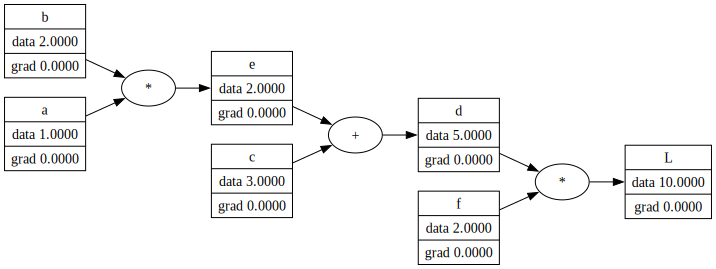

In [170]:
draw_dot(L)

In [171]:
672008
    dL / dc = dL/dd * dd/dc =
    dd / dc ? = 1.0
    d = c + e
    
    dL / da = (dL/de) * (de/da)
    de / da = b
    dL / de = dL/dd * dd/de = f
    dL / da = f * b
"""

'\n    dL / dc = dL/dd * dd/dc =\n    dd / dc ? = 1.0\n    d = c + e\n    \n    dL / da = (dL/de) * (de/da)\n    de / da = b\n    dL / de = dL/dd * dd/de = f\n    dL / da = f * b\n'

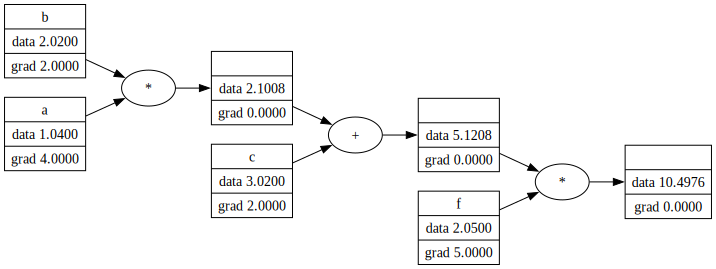

In [173]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
draw_dot(L)

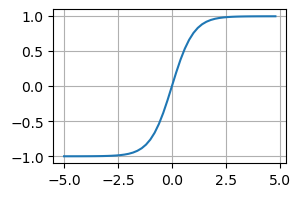

In [174]:
# Activation function example
plt.figure(figsize=(3,2))
plt.plot(np.arange(-5,5, 0.2), np.tanh(np.arange(-5,5, 0.2))); plt.grid()


In [175]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137358, label='b')

# output x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1 + x2w2'
n = x1w1_x2w2 + b; n.label = 'n' 
o = n.tanh(); o.label = 'o'

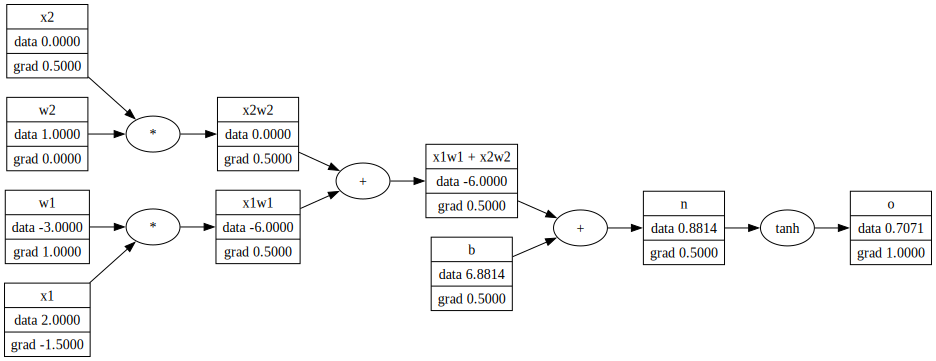

In [176]:
o.backward()
draw_dot(o)

In [177]:
o.grad = 1.0
n.grad = (1.0 - o.data**2) * o.grad
x1w1_x2w2.grad = 1.0 * n.grad
b.grad = 1.0 * n.grad
x1w1.grad = 1.0 * x1w1_x2w2.grad
x2w2.grad = 1.0 * x1w1_x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [178]:
o.grad = 1.0
o._backward()
n._backward()
x1w1_x2w2._backward()
x2w2._backward()
x1w1._backward()